<a href="https://colab.research.google.com/github/Suniaster/COP-Kmeans/blob/main/FSI_COP_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COP - Kmeans

In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets

## Dividindo Data-set

In [2]:

iris = datasets.load_iris()
iris.target

X = np.concatenate( (iris.data, np.array([iris.target]).T), axis=1)

In [3]:
# X = data.to_numpy();
# labels_dict = { 
#    'Iris-versicolor': 0,
#     'Iris-virginica': 1,
#     'Iris-setosa': 2
# }
# for row in X:
#   row[4] = labels_dict[row[4]]

In [4]:
# Remover algumas labels
x_unlabeled, x_labeled = train_test_split(X, train_size=0.8)

for row in x_unlabeled:
  row[4] = None

dataset = np.concatenate((x_labeled, x_unlabeled))
dataset = dataset.tolist()
for row in dataset:
  if np.isnan(row[4]):
    row[4] = None

## COP

In [5]:
# Criando resticoes
def create_retrictions(dataset):
  must_link = []
  must_not_link = []
  for i in range(len(dataset)):
    for j in range(len(dataset)):
      if i == j or i > j:
        continue
      if dataset[i][4] == None or dataset[j][4] == None:
        continue
      if dataset[i][4] == dataset[j][4]:
        must_link.append( (i, j) )
      else:
        must_not_link.append((i,j))
  return must_link, must_not_link

In [6]:
def create_clusters():
  n_cluster = 3
  clusters = []
  centroids = []

  for i in range(len(dataset)):
    if  dataset[i][4] is None:
      continue
    label_found = False
    for centroid in centroids:
      if centroid[4] ==  dataset[i][4]:
        label_found = True
    if label_found == False:
      centroids.append( dataset[i])
      clusters.append([i])
  return centroids, clusters

In [7]:
def rule_check(rule, i, j):
  if rule[0] == i and rule [1] == j:
    return True
  if rule[1] == i and rule [0] == j:
    return True
  return False

In [8]:
def violate_constraint(evaluated_index, cluster, must_link, not_link):
    for rule in not_link:
      for cluster_point in cluster:
        if rule_check(rule, cluster_point, evaluated_index):
          return True
    return False

def data_set_dist(row1, row2):
  sum = 0
  for i in range(len(row[:-1])):
    sum += (row1[i] - row2[i])**2
  return sum

violate_constraint(1, [0], [], [(0, 1)])

True

In [9]:
def get_closest_cluster_index(centroids, dataset_row, idx, must_link, must_not_link):
  min_dist  = 100000000000
  min_index = None
  for i in range(len(centroids)):
    distance = data_set_dist(centroids[i], dataset_row)
    if distance < min_dist and not violate_constraint(idx, clusters[i], must_link, must_not_link):
      min_dist = distance
      min_index = i
  return min_index

In [10]:
def get_cluster_data(cluster_idx):
  cluster_data = []
  for idx in clusters[cluster_idx]:
    cluster_data.append(dataset[idx])
  return np.asarray(cluster_data)

In [11]:
def reset_clusters(clusters):
  new_clusters = []
  for cluster in clusters:
    new_clusters.append([cluster[0]])
  return new_clusters

## Loop Principal

In [12]:
## Rotina principal
centroids, clusters = create_clusters()
must_link, not_link = create_retrictions(dataset)
max_iter = 20
for iter in range(max_iter):
  clusters = reset_clusters(clusters)

  ## Assign Clusters
  for i in range(len(dataset)):
    d = dataset[i]
    cluster_idx = get_closest_cluster_index(centroids, d, i, must_link, not_link)
    if cluster_idx is None:
      print("ERROR: Falhou")
      break
    if i not in clusters[cluster_idx]:
      clusters[cluster_idx].append(i)

  ## Recalculate Centroids
  for cluster_idx in range(len(clusters)):
    cluster_data = get_cluster_data(cluster_idx)
    centroids[cluster_idx] = np.mean(cluster_data[:,0:4], axis=0)

# Calculando estatísticas

Calculando a distância intra cluster

In [13]:
within_cluster_distances = []


for cluster_idx in range(len(clusters)):
    cluster_data = get_cluster_data(cluster_idx)
    cluster_distance = 0
    centroid_dist=[]
    for j in range(len(cluster_data)):
      
      centroid_dist.append(np.linalg.norm(centroids[cluster_idx] - cluster_data[j, 0:4]))

    cluster_distance += np.sum(centroid_dist)
    

    within_cluster_distances.append(((cluster_distance) / len(clusters)))
        
    
      
print(within_cluster_distances)

[13.022306607170757, 11.929253365649034, 8.02842060772114]


Calculando distância entre clusters

In [14]:
inter_cluster_distance_matrix = np.zeros((len(clusters), len(clusters)))

for cluster_idx_i in range(len(clusters)):
    for cluster_idx_j in range(len(clusters)):
      inter_cluster_distance_matrix[cluster_idx_i][cluster_idx_j] = np.linalg.norm(centroids[cluster_idx_i] - centroids[cluster_idx_j])
     
inter_cluster_distance_matrix
    

array([[0.        , 1.67622579, 3.28105443],
       [1.67622579, 0.        , 4.84588987],
       [3.28105443, 4.84588987, 0.        ]])

## Plotando Dados

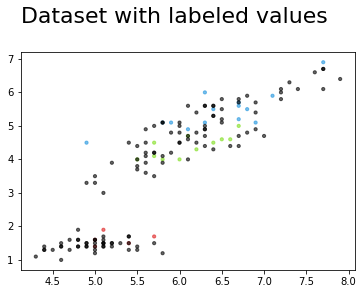

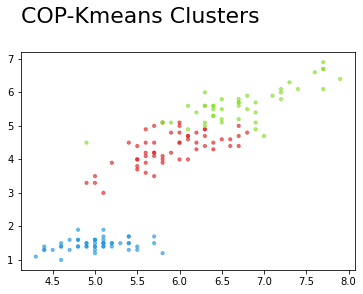

In [15]:
cluster = get_cluster_data(0)
colors = ['#DF2020', '#81DF20', '#2095DF']
colors_dict = { 
    0: '#DF2020',
    1: '#81DF20',
    2: '#2095DF',
    None: '#000000'
}
colors = []
for data in dataset:
  colors.append(colors_dict[data[4]])
dt = np.array(dataset)

plt.scatter(dt[:,0:1],dt[:,2:3], c=colors, alpha = 0.6, s=10)
plt.title('Dataset with labeled values\n', loc='left', fontsize=22)
plt.show()

all_clusters = np.concatenate((get_cluster_data(0), get_cluster_data(1), get_cluster_data(2)))
colors = []
for i in range(3):
  for data in get_cluster_data(i):
    colors.append(colors_dict[i])

plt.scatter(all_clusters[:,0:1],all_clusters[:,2:3], c=colors, alpha = 0.6, s=10)
plt.title('COP-Kmeans Clusters\n', loc='left', fontsize=22)
plt.show()


# Kmeans K-learn

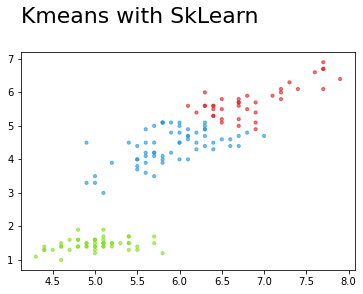

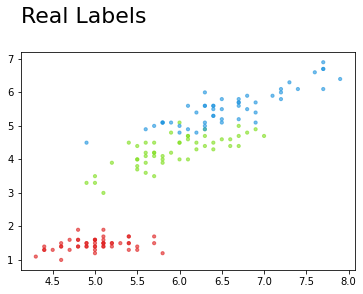

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
skX = X[:,0:4]

kmeans = KMeans(n_clusters=3, random_state=0).fit(skX)
colors = []
for label in kmeans.labels_:
  colors.append(colors_dict[label])

plt.scatter(skX[:,0:1],skX[:,2:3], c=colors, alpha = 0.6, s=10)
plt.title('Kmeans with SkLearn\n', loc='left', fontsize=22)
plt.show()

colors = []
for label in X[:,4:5]:
  colors.append(colors_dict[label[0]])

plt.scatter(skX[:,0:1],skX[:,2:3], c=colors, alpha = 0.6, s=10)
plt.title('Real Labels\n', loc='left', fontsize=22)
plt.show()


## Estatisticas
